📊 MAE:  0.012300
📊 RMSE: 0.016398


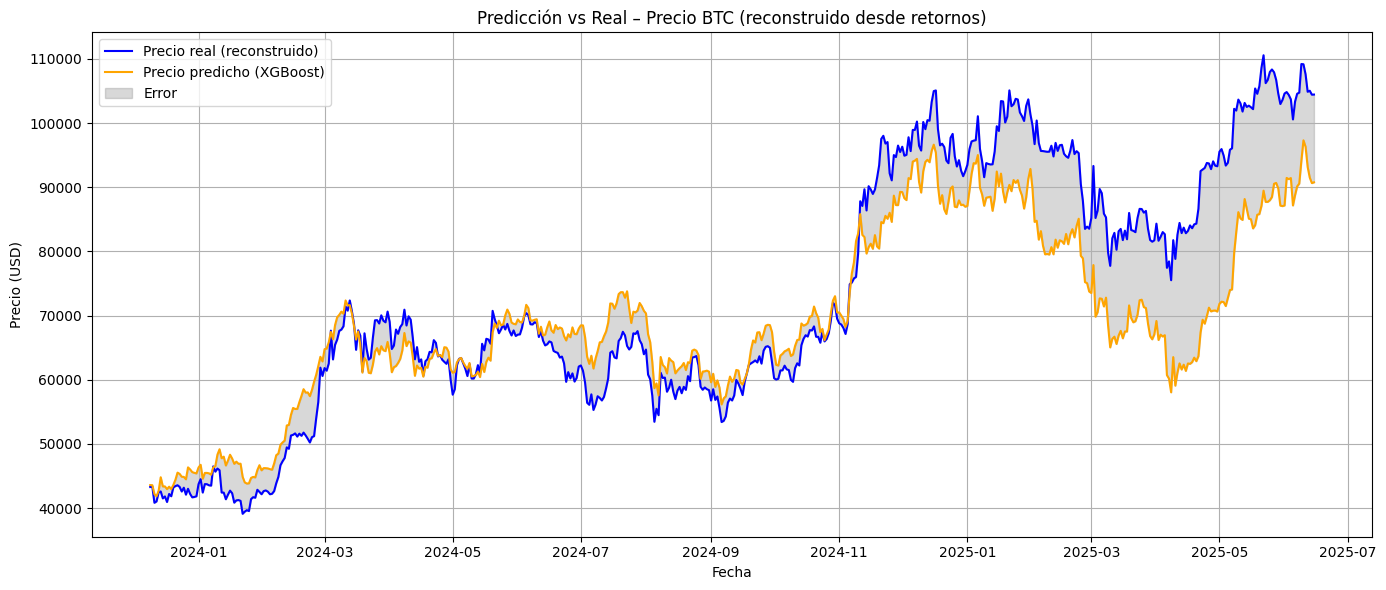

In [2]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 1. Cargar el CSV con los datos
df = pd.read_csv("../datasets/merged/master_improved.csv", index_col=0, parse_dates=True)
df = df.reset_index().rename(columns={'index': 'ds'})

# 2. Definir objetivo y regresores
target = 'btc_log_return'
regresores_externos = ['eth_log_return', 'sp500_log_return', 'gold_log_return', 'dxy_log_return']

# ,btc_close,active_addresses,dxy_close,eth_close,fear_greed,gold_close,interest_rate,sp500_close,trend,btc_log_return,btc_rsi,eth_log_return,sp500_log_return,gold_log_return,dxy_log_return,btc_log_cumsum,active_addresses_pct_change,trend_diff


lags = [1, 2, 3]

# 3. Crear lags del retorno
for lag in lags:
    df[f'lag_{lag}'] = df[target].shift(lag)

# 4. Seleccionar columnas de entrada y salida
features = [f'lag_{lag}' for lag in lags] + regresores_externos
df_model = df[['ds', target] + features].dropna().copy()

# 5. Separar en entrenamiento y prueba (80/20)
train_size = int(len(df_model) * 0.8)
train = df_model.iloc[:train_size]
test = df_model.iloc[train_size:]

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

# 6. Entrenar modelo XGBoost
model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# 7. Hacer predicciones
y_pred = model.predict(X_test)

# 8. Calcular métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"📊 MAE:  {mae:.6f}")
print(f"📊 RMSE: {rmse:.6f}")


# Precio real al inicio del test
P0 = df.loc[test.index[0], 'btc_close']

# Retornos acumulados
log_price_real = np.exp(np.cumsum(y_test))
log_price_pred = np.exp(np.cumsum(y_pred))

# Reconstrucción de precios
price_real = P0 * log_price_real
price_pred = P0 * log_price_pred

# 10. Gráfico de precios reales vs predichos
plt.figure(figsize=(14, 6))
plt.plot(test['ds'], price_real, label='Precio real (reconstruido)', color='blue')
plt.plot(test['ds'], price_pred, label='Precio predicho (XGBoost)', color='orange')
plt.fill_between(test['ds'], price_real, price_pred, color='gray', alpha=0.3, label='Error')
plt.title('Predicción vs Real – Precio BTC (reconstruido desde retornos)')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()